In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

import pywt
import random

In [14]:
file_path =  "./Data/S1_E1_A1.mat"
save_figures_path = "Figures/"
data_folder =  "Data/"

mat_data = loadmat(file_path) 
data = mat_data.copy()

print("Done")

Done


In [15]:
val_data = loadmat("./Data/S1_E1_A2.mat") 
test_data = loadmat("./Data/S1_E1_A3.mat") 

print("Done")

Done


In [16]:
print("Train set")
print([key for key in mat_data.keys()])
print("Validation set")
print([key for key in mat_data.keys()])
print("Test set")
print([key for key in mat_data.keys()])

#They are the same for the three sets


Train set
['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition']
Validation set
['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition']
Test set
['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition']


In [17]:
#Train set key filtering
useless_keys = ['exercise', 'stimulus', 'repetition', 'restimulus', 'rerepetition', 'subject',
                'gyro', 'acc', 'mag']

data = {key: value for key, value in data.items() if not key.startswith("__")}
data = {key: value for key, value in data.items() if not key in useless_keys}

print([key for key in data.keys()])

['emg', 'acc', 'gyro', 'mag', 'glove']


In [19]:
#Validation set key filtering

val_data = {key: value for key, value in val_data.items() if not key.startswith("__")}
val_data = {key: value for key, value in val_data.items() if not key in useless_keys}

print([key for key in val_data.keys()])

['emg', 'acc', 'gyro', 'mag', 'glove']


In [20]:
#Test set key filtering

test_data = {key: value for key, value in test_data.items() if not key.startswith("__")}
test_data = {key: value for key, value in test_data.items() if not key in useless_keys}

print([key for key in test_data.keys()])

['emg', 'acc', 'gyro', 'mag', 'glove']


In [21]:
#Exploring the number of repetitions of the train set

print("List of repetition values: ", np.unique(mat_data["repetition"]))
print("List of rerepetition values: ", np.unique(mat_data["rerepetition"]))

List of repetition values:  [ 0  1  2  3  4  5  6  7  8  9 10]
List of rerepetition values:  [ 0  1  2  3  4  5  6  7  8  9 10]


In [22]:
# Exploration
fs = 2000 #Hz

emg = data["emg"].copy()

n_timepoints = emg.shape[0]
n_channels = emg.shape[1]
print("Nb of channels: ", n_channels)
print("Nb of timepoints: ", n_timepoints)

Nb of channels:  16
Nb of timepoints:  2292526


check the level of filtering already performed (low, high cut and common frequency and their armonics)

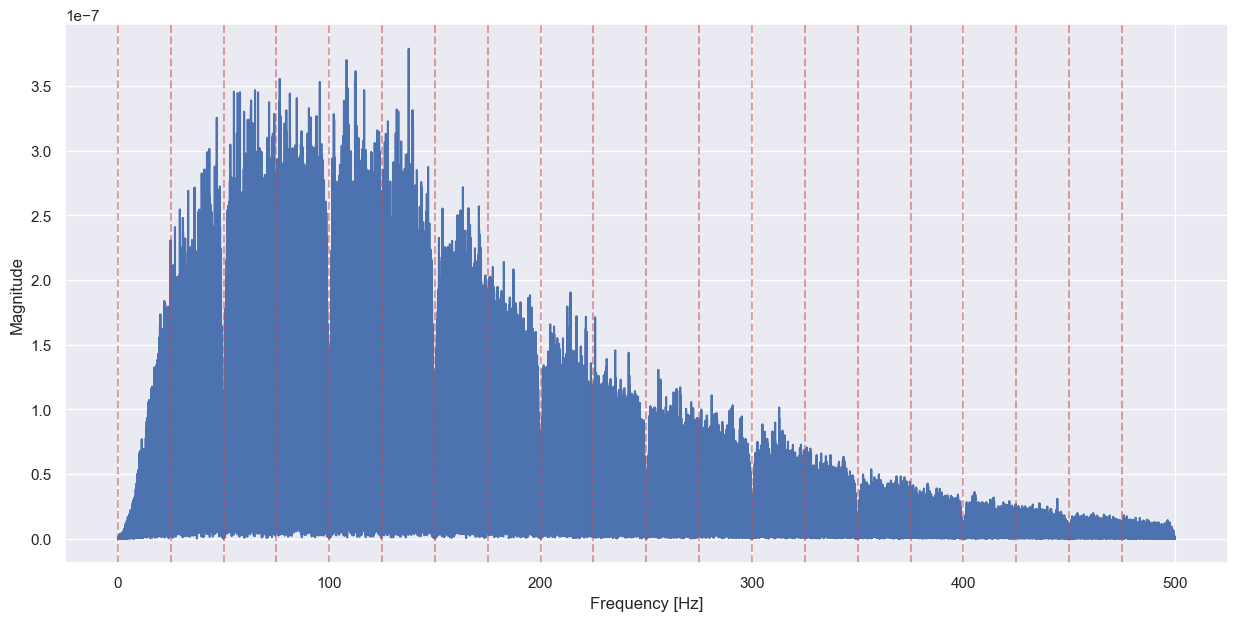

In [23]:
#We check the frequency compotision of the signal to 
#verify if it has been filtrated correctly (5-500 Hz, and deletion of grid harmonics)


n_samples = emg.shape[0]
freq = fftfreq(n_samples, 1/fs)[:n_samples//2]

fft_vals = fft(emg[:, 0])
magnitude = 2.0/n_samples * np.abs(fft_vals[0:n_samples//2])

zoom = len(freq)//2

plt.figure(figsize=(15, 7))
plt.plot(freq[:zoom], magnitude[:zoom])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)

for freq_line in range(0, int(max(freq[:zoom])), 25):
    if freq_line <= fs/2:  # Only plot up to Nyquist
        plt.axvline(x=freq_line, color='r', linestyle='--', alpha=0.5)

plt.show()

the 50hz and its hardmonic have already been filtered out

In [33]:
#We show the 

n_channels = emg.shape[1]

joints_of_interest = np.array([3, 6, 8, 11, 14]) - 1
n_joints = len(joints_of_interest)

preprocessed_train = data.copy()
preprocessed_val = val_data.copy()
preprocessed_test = test_data.copy()

#Time vector for plotting
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) 


#We rectify emg data for the three of them
preprocessed_train['emg'] = np.abs(preprocessed_train['emg']) 
preprocessed_val['emg'] = np.abs(preprocessed_val['emg']) 
preprocessed_test['emg'] = np.abs(preprocessed_test['emg']) 

['emg', 'acc', 'gyro', 'mag', 'glove']


#We define the moving average window. A longer one is used for the glove angles than emg
mov_mean_length_glove = int(128*1e-3*fs) #128 ms for the glove angles
mov_mean_weights_glove = np.ones(mov_mean_length_glove) / mov_mean_length_glove

#We define another one for the emg. It should be shorter to keep the signal quality over window
mov_mean_length_emg = int(20*1e-3*fs) #20 ms for the emg data
mov_mean_weights_emg = np.ones(mov_mean_length_emg) / mov_mean_length_emg


#We smooth all the data with a moving average
for key in preprocessed_data.keys():
    if key == "glove":
        preprocessed_train[key] = convolve1d(preprocessed_train[key], mov_mean_weights_glove, axis=0)
    elif key == "emg":
        preprocessed_train[key] = convolve1d(preprocessed_train[key], mov_mean_weights_emg, axis=0)

    
for key in preprocessed_val.keys():
    if key == "glove":
        preprocessed_val[key] = convolve1d(preprocessed_val[key], mov_mean_weights_glove, axis=0) 
    elif  key == "emg":
        preprocessed_val[key] = convolve1d(preprocessed_val[key], mov_mean_weights_emg, axis=0) 


for key in preprocessed_test.keys():
    if key == "glove":
        preprocessed_test[key] = convolve1d(preprocessed_test[key], mov_mean_weights_glove, axis=0) 
    elif key == "emg":
        preprocessed_test[key] = convolve1d(preprocessed_test[key], mov_mean_weights_emg, axis=0) 

#We store them in variables
EMG_envelopes_train = preprocessed_train['emg']
glove_envelopes_train = preprocessed_train['glove'][:, joints_of_interest]

EMG_envelopes_val = preprocessed_val['emg']
glove_envelopes_val = preprocessed_val['glove'][:, joints_of_interest]

EMG_envelopes_test = preprocessed_test['emg']
glove_envelopes_test = preprocessed_test['glove'][:, joints_of_interest]

print("Done")

Done


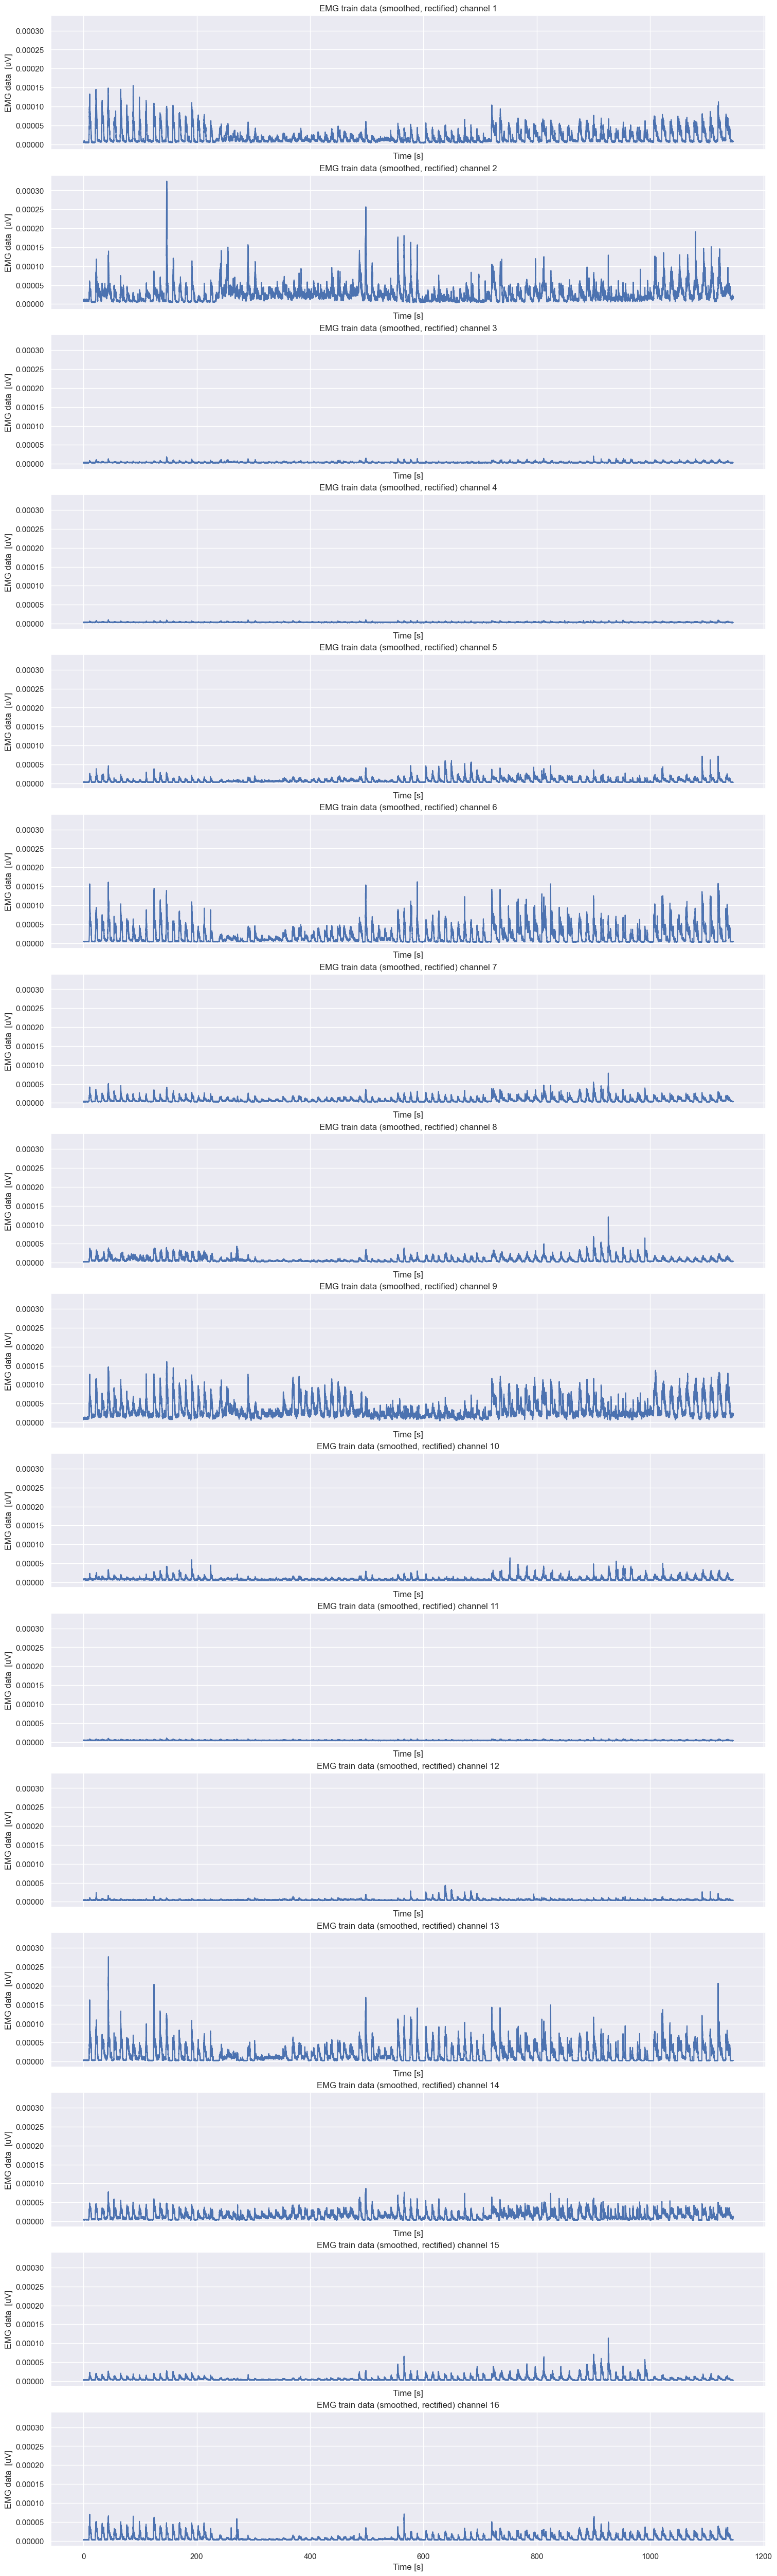

In [32]:
#We plot the smoothed, rectified data for each channel (TRAIN data)
fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 50), sharex=True, sharey=True)
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, EMG_envelopes_train[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f"EMG data  [uV]")
    ax[channel_idx].set_title(f"EMG train data (smoothed, rectified) channel {channel_idx+1}")

plt.show()

In [25]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 150e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

print("Done")

In [27]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

print("Done")

Done


In [36]:
from sklearn.model_selection import train_test_split

#We perform sliding window on the three sets to extract the features later
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_envelopes_train, glove_envelopes_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_val_windows, Labels_val_windows = extract_time_windows_regression(EMG_envelopes_val, glove_envelopes_val, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_envelopes_test, glove_envelopes_test, fs, emg_window_length_sec, incremental_window_length_sec)

# randomly pick data for train, validation and test => we don't do that anymore
#EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=151)

print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG val data shape: {EMG_val_windows.shape}, Val label shape: {Labels_val_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

EMG train data shape: (22923, 300, 16), Train label shape: (22923, 300, 5)
EMG val data shape: (23132, 300, 16), Val label shape: (23132, 300, 5)
EMG test data shape: (5288, 300, 16), Test label shape: (5288, 300, 5)


In [145]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    EMG_rms = np.sqrt(np.mean(np.square(EMG_windows), axis=1)) 
    EMG_wl = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1) #kind of the total activity
    EMG_scc = np.sum(np.diff(np.sign(np.diff(EMG_windows, axis=1)), axis=1) != 0, axis=1)

    Labels_mean = np.mean(Labels_windows,axis=1)

    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((
        EMG_mean, 
        EMG_std, 
        EMG_max_amplitude,
        EMG_rms,
        EMG_wl,
        EMG_scc,
    ), axis=1)
    return EMG_extracted_features, Labels_mean

In [146]:
#We extract the features

EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_val_windows,Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

#We print their dimensions
print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (22923, 96), Fingler labels feature shape:(22923, 5)
EMG val extracted features shape: (5288, 96), Fingler labels feature shape:(5288, 5)
EMG test extracted features shape: (5288, 96), Fingler labels feature shape:(5288, 5)


In [115]:
#Explication de la dimension des données:
# (91697, 48) => 91697 timepoints, 48 features
# (91697, 18) => 91697 timepoints, 18 gloves parts

In [147]:
#We normalize the features, and keep the normalization parameters. They will be used for validation and testing
#We use z-score normalization, because the EMG data may contain outliers

#Normalization matrices
norm_mean = np.mean(EMG_train_extracted_features, axis=0)
norm_std = np.std(EMG_train_extracted_features, axis=0)

#We print its dimensions
print(f"Mean matrix shape: {norm_mean.shape}")
print(norm_mean)

print(f"Std matrix shape: {norm_std.shape}")
print(norm_std)

Mean matrix shape: (96,)
[1.87204191e-05 2.62155463e-05 3.68305727e-06 3.32188771e-06
 7.34326851e-06 1.88338311e-05 7.61774886e-06 7.85332198e-06
 3.32553902e-05 8.67344910e-06 4.31127820e-06 5.00739747e-06
 1.85706060e-05 1.50329581e-05 5.80731894e-06 8.01721746e-06
 5.92119037e-06 9.98068707e-06 9.48738279e-07 7.39681423e-07
 2.46039510e-06 6.73472333e-06 2.33427011e-06 3.23535469e-06
 1.02424540e-05 2.13506941e-06 7.76531843e-07 1.29067332e-06
 7.42029134e-06 6.21698394e-06 1.71934474e-06 2.55572851e-06
 3.26906091e-05 4.96379693e-05 5.93080306e-06 5.04390456e-06
 1.32885239e-05 3.48451139e-05 1.32115002e-05 1.59907260e-05
 5.71893358e-05 1.37923078e-05 6.13173681e-06 8.09928148e-06
 3.62512673e-05 2.97585832e-05 9.95875824e-06 1.42002711e-05
 1.96977790e-05 2.81784878e-05 3.81205416e-06 3.40731097e-06
 7.78476503e-06 2.00923671e-05 7.99577130e-06 8.56428099e-06
 3.49040950e-05 8.96234013e-06 4.38411280e-06 5.19049546e-06
 2.01712927e-05 1.63627488e-05 6.08633583e-06 8.45645704e-06

In [148]:
#Normalization function

def normalize(x, mean_matrix, std_matrix):
    return (x - mean_matrix)/std_matrix

In [149]:
#Fit and predict using the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

print("Base")
print(np.mean(EMG_test_extracted_features, axis=0))

#We put these into the relevant variables for fitting/evaluation
X_train = normalize(EMG_train_extracted_features, norm_mean, norm_std)
X_val = normalize(EMG_val_extracted_features, norm_mean, norm_std)
X_test = normalize(EMG_test_extracted_features, norm_mean, norm_std)

Y_train = Labels_train_mean
Y_val = Labels_val_mean
Y_test = Labels_test_mean

print("Train set shape")
print(X_train.shape)
print(Y_train.shape)

print("Validation set shape")
print(X_val.shape)
print(Y_val.shape)

print("Test set shape")
print(X_test.shape)
print(Y_test.shape)

#To check if normalization has been done properly
#We observe that normalization works well accross the sets
print(np.mean(X_test, axis=0))
print(np.std(X_test, axis=0))

Base
[1.75795548e-05 2.60845081e-05 3.51160567e-06 3.18245663e-06
 7.13075379e-06 1.63707382e-05 7.13604876e-06 6.87469433e-06
 3.12068013e-05 8.17394421e-06 3.47574499e-06 4.66644676e-06
 1.58057989e-05 1.34691128e-05 5.55536945e-06 8.38264480e-06
 5.71129284e-06 1.09574316e-05 9.42570737e-07 7.33446408e-07
 2.61360856e-06 6.22714790e-06 2.16683118e-06 2.63816776e-06
 9.99669259e-06 2.27157045e-06 7.38287092e-07 1.42917824e-06
 6.37429980e-06 6.11335193e-06 1.84088403e-06 2.83052759e-06
 3.09778342e-05 5.12445292e-05 5.76087572e-06 4.88944975e-06
 1.33314962e-05 3.07790001e-05 1.23072235e-05 1.32833621e-05
 5.43858220e-05 1.36099815e-05 5.18500778e-06 8.11026670e-06
 3.08293818e-05 2.76391550e-05 9.92000836e-06 1.51630348e-05
 1.85531494e-05 2.84553229e-05 3.64609802e-06 3.27256918e-06
 7.64211118e-06 1.76116656e-05 7.48318931e-06 7.42136286e-06
 3.28911713e-05 8.52366571e-06 3.55747091e-06 4.90794530e-06
 1.71973855e-05 1.49212352e-05 5.88117175e-06 8.90055545e-06
 1.21086595e-04 2.0

In [150]:
def compute_corr_matrix_normalized(X): 
    #We standardize the features before to avoid any scaling effect
    # X_corr_mean = np.mean(X_corr, axis=0) 
    # X_corr_std = np.std(X_corr, axis=0)
    # X_corr_normalized = (X_corr - X_corr_mean) / X_corr_std
    
    # Calculate the cross-correlation matrix (Pearson correlation)
    corr_matrix = np.corrcoef(X, rowvar=False)

    return corr_matrix

print("Done")

Done


In [151]:
n_features_channels = 6

#Visualize the full correlation matrix
X_corr = X_train
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels*n_features_channels+1) #Times 

fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("Features")
ax.set_xlabel("Features")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_features.png", dpi=300, bbox_inches="tight")
plt.show()

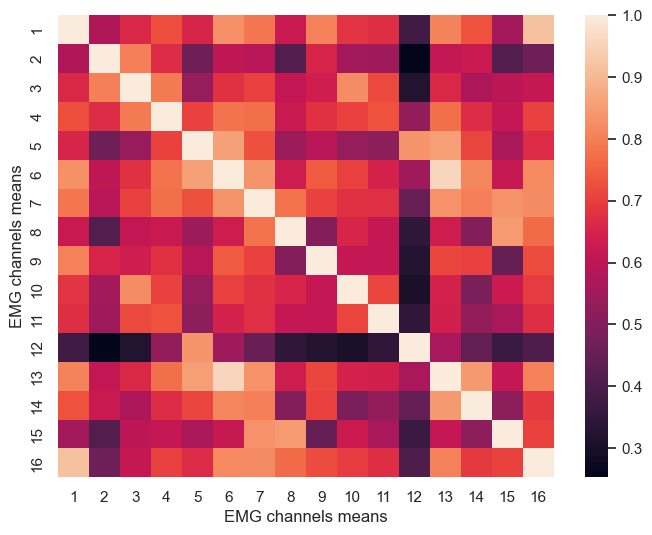

In [152]:
#Visualize the full correlation matrix
X_corr = X_train[:, 0:n_channels] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels means")
ax.set_xlabel("EMG channels means")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_means.png", dpi=300, bbox_inches="tight")
plt.show()

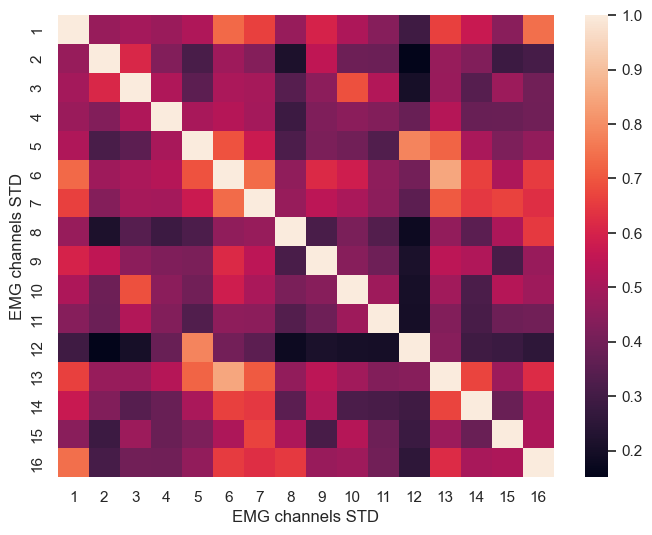

In [153]:
#Visualize the full correlation matrix
X_corr = X_train[:, n_channels*1:n_channels*2] #The STDS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels STD")
ax.set_xlabel("EMG channels STD")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()

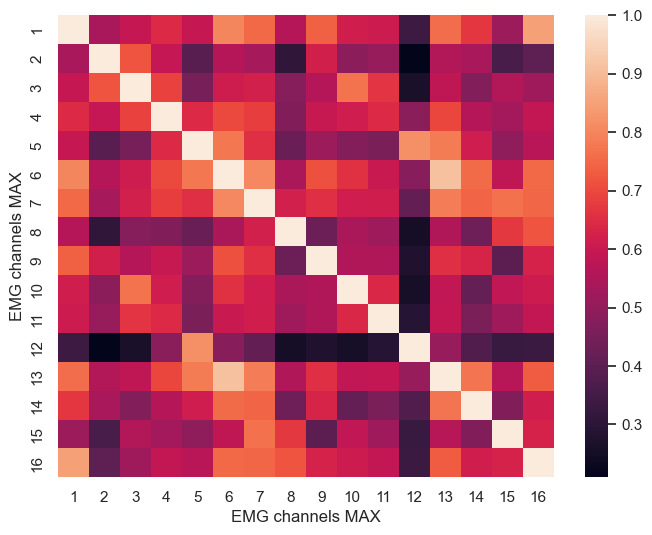

In [154]:
#Visualize the full correlation matrix
X_corr = X_train[:, n_channels*2:n_channels*3] #The MAX values are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels MAX")
ax.set_xlabel("EMG channels MAX")



#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()




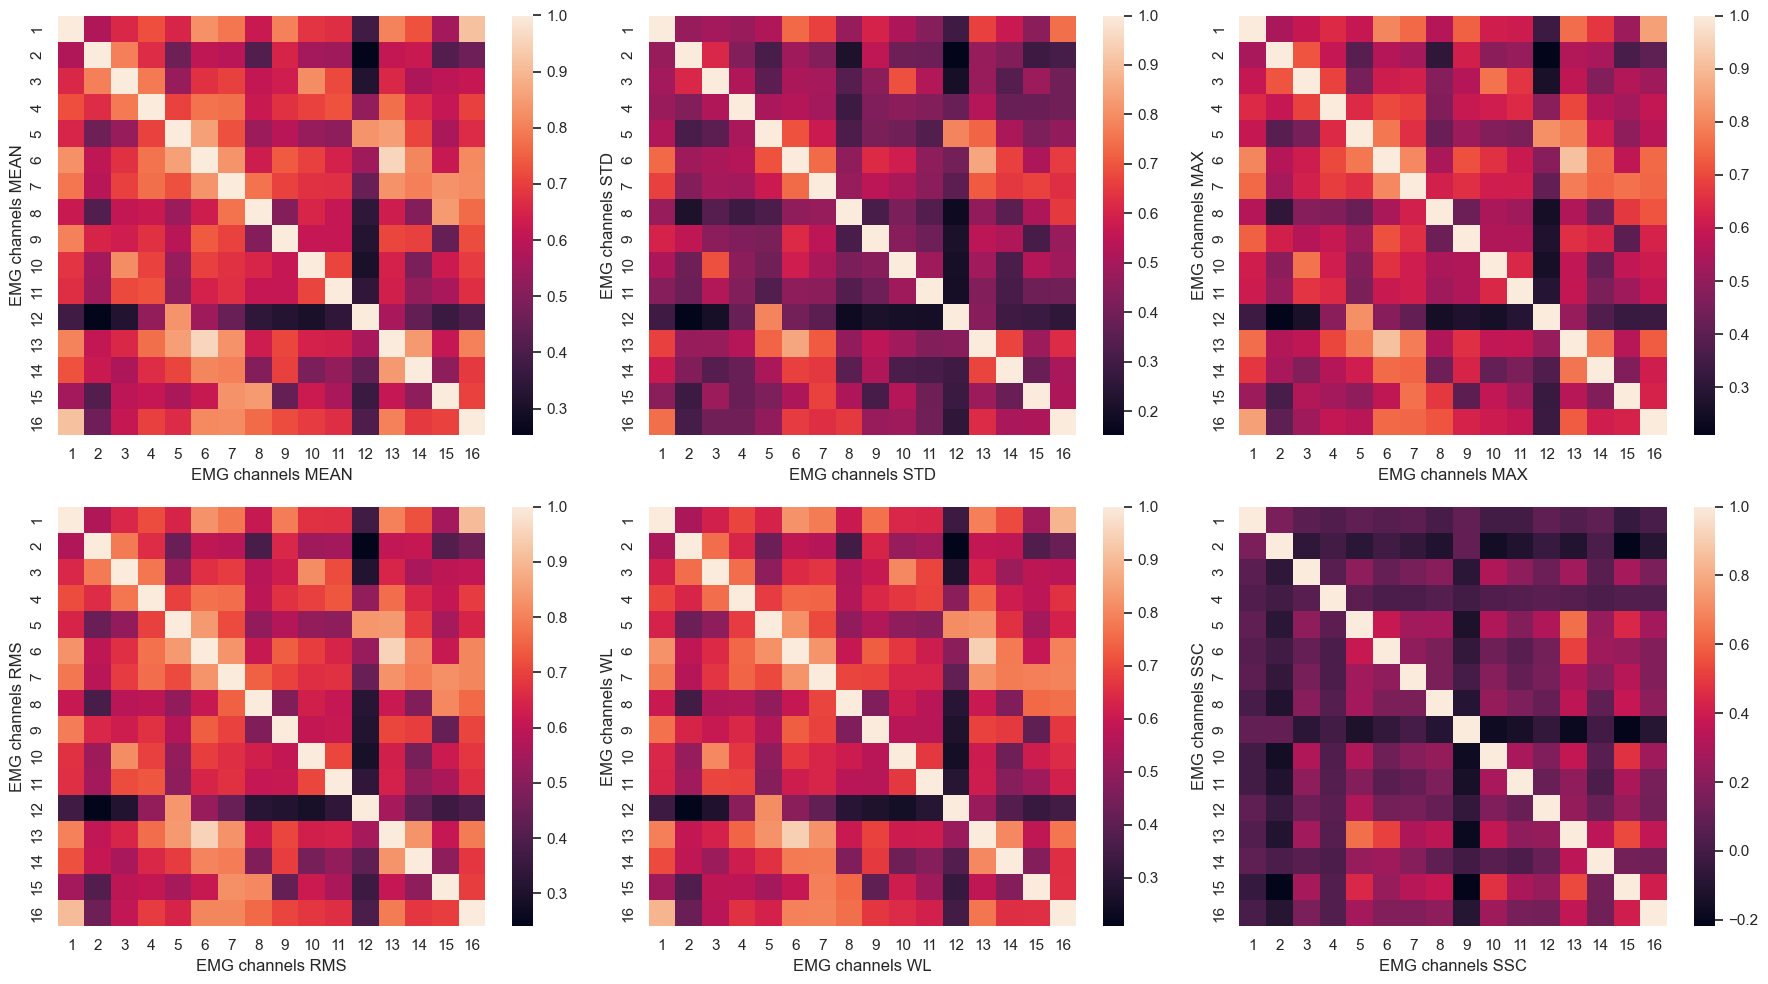

In [158]:
n_rows, n_columns = 2, 3

fig, axes = plt.subplots(n_rows, n_columns, figsize=(18, 10))

axes = axes.flatten()

all_channels = np.arange(1, n_channels+1)


X_corr = X_train[:, 0:n_channels] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[0], xticklabels=all_channels, yticklabels=all_channels)
axes[0].set_ylabel("EMG channels MEAN")
axes[0].set_xlabel("EMG channels MEAN")


X_corr = X_train[:, n_channels:n_channels*2] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[1], xticklabels=all_channels, yticklabels=all_channels)
axes[1].set_ylabel("EMG channels STD")
axes[1].set_xlabel("EMG channels STD")


X_corr = X_train[:, n_channels*2:n_channels*3] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[2], xticklabels=all_channels, yticklabels=all_channels)
axes[2].set_ylabel("EMG channels MAX")
axes[2].set_xlabel("EMG channels MAX")

X_corr = X_train[:, n_channels*3:n_channels*4] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[3], xticklabels=all_channels, yticklabels=all_channels)
axes[3].set_ylabel("EMG channels RMS")
axes[3].set_xlabel("EMG channels RMS")

X_corr = X_train[:, n_channels*4:n_channels*5] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[4], xticklabels=all_channels, yticklabels=all_channels)
axes[4].set_ylabel("EMG channels WL")
axes[4].set_xlabel("EMG channels WL")

X_corr = X_train[:, n_channels*5:n_channels*6] #The MEANS are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)

sns.heatmap(corr_matrix, ax=axes[5], xticklabels=all_channels, yticklabels=all_channels)
axes[5].set_ylabel("EMG channels SSC")
axes[5].set_xlabel("EMG channels SSC")



# Save and visualize
plt.tight_layout()
save_figures_path = "./"
plt.savefig(save_figures_path + "correlation_subplot_grid.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'n_stimuli' is not defined

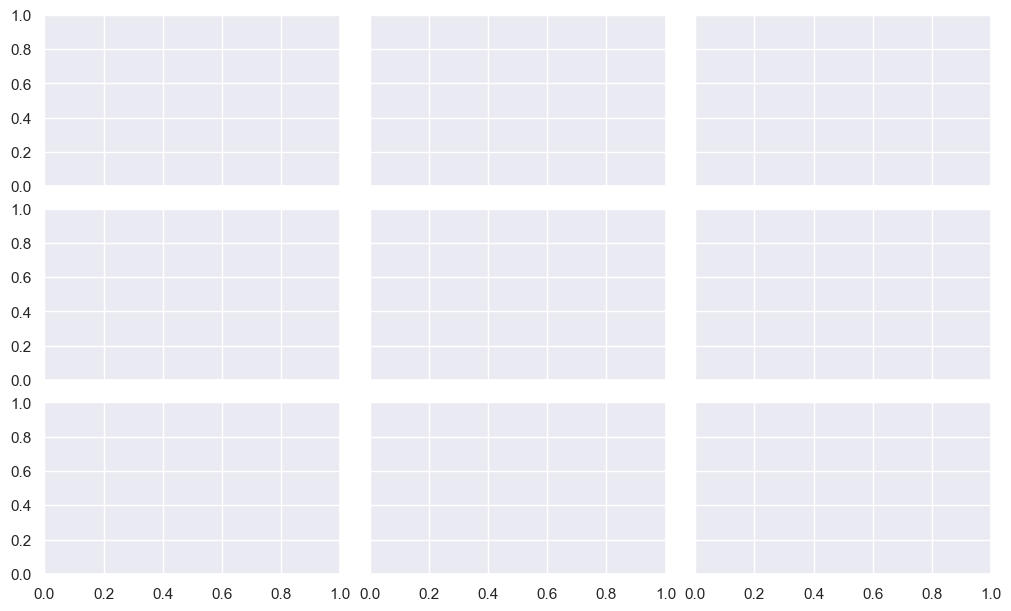

In [104]:
#We draw the hotmaps of the different features. Do they correlate with the stimuli reliably?

fig, ax = plt.subplots(3, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

#Visualize the full correlation matrix
X_corr = X_train[:, 3::n_features_channels] #The MAX values are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels RMS")
ax.set_xlabel("EMG channels RMS")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()


#Visualize the full correlation matrix
X_corr = X_train[:, 4::n_features_channels] #The MAX values are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels WL")
ax.set_xlabel("EMG channels WL")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()


#Visualize the full correlation matrix
X_corr = X_train[:, 5::n_features_channels] #The MAX values are extracted
corr_matrix = compute_corr_matrix_normalized(X_corr)


all_channels = np.arange(1, n_channels+1) #Times 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax, xticklabels=all_channels, yticklabels=all_channels)
ax.set_ylabel("EMG channels SCC")
ax.set_xlabel("EMG channels SCC")

#plt.title("Confusion Matrix")
plt.savefig(save_figures_path + "correlation_matrix_stds.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Define the base model
base_model = GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42)

# Wrap the model in MultiOutputRegressor
multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, Y_train)
Y_pred = multi_model.predict(X_test)

print("Done")

In [ ]:
print("Done")

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Compute the errors. Each column is the error for a target

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')

print(mse.shape)

(5,)


In [22]:
print(mse)

[180.11904088 427.66147952 869.79270259 673.78505966 715.8651935 ]


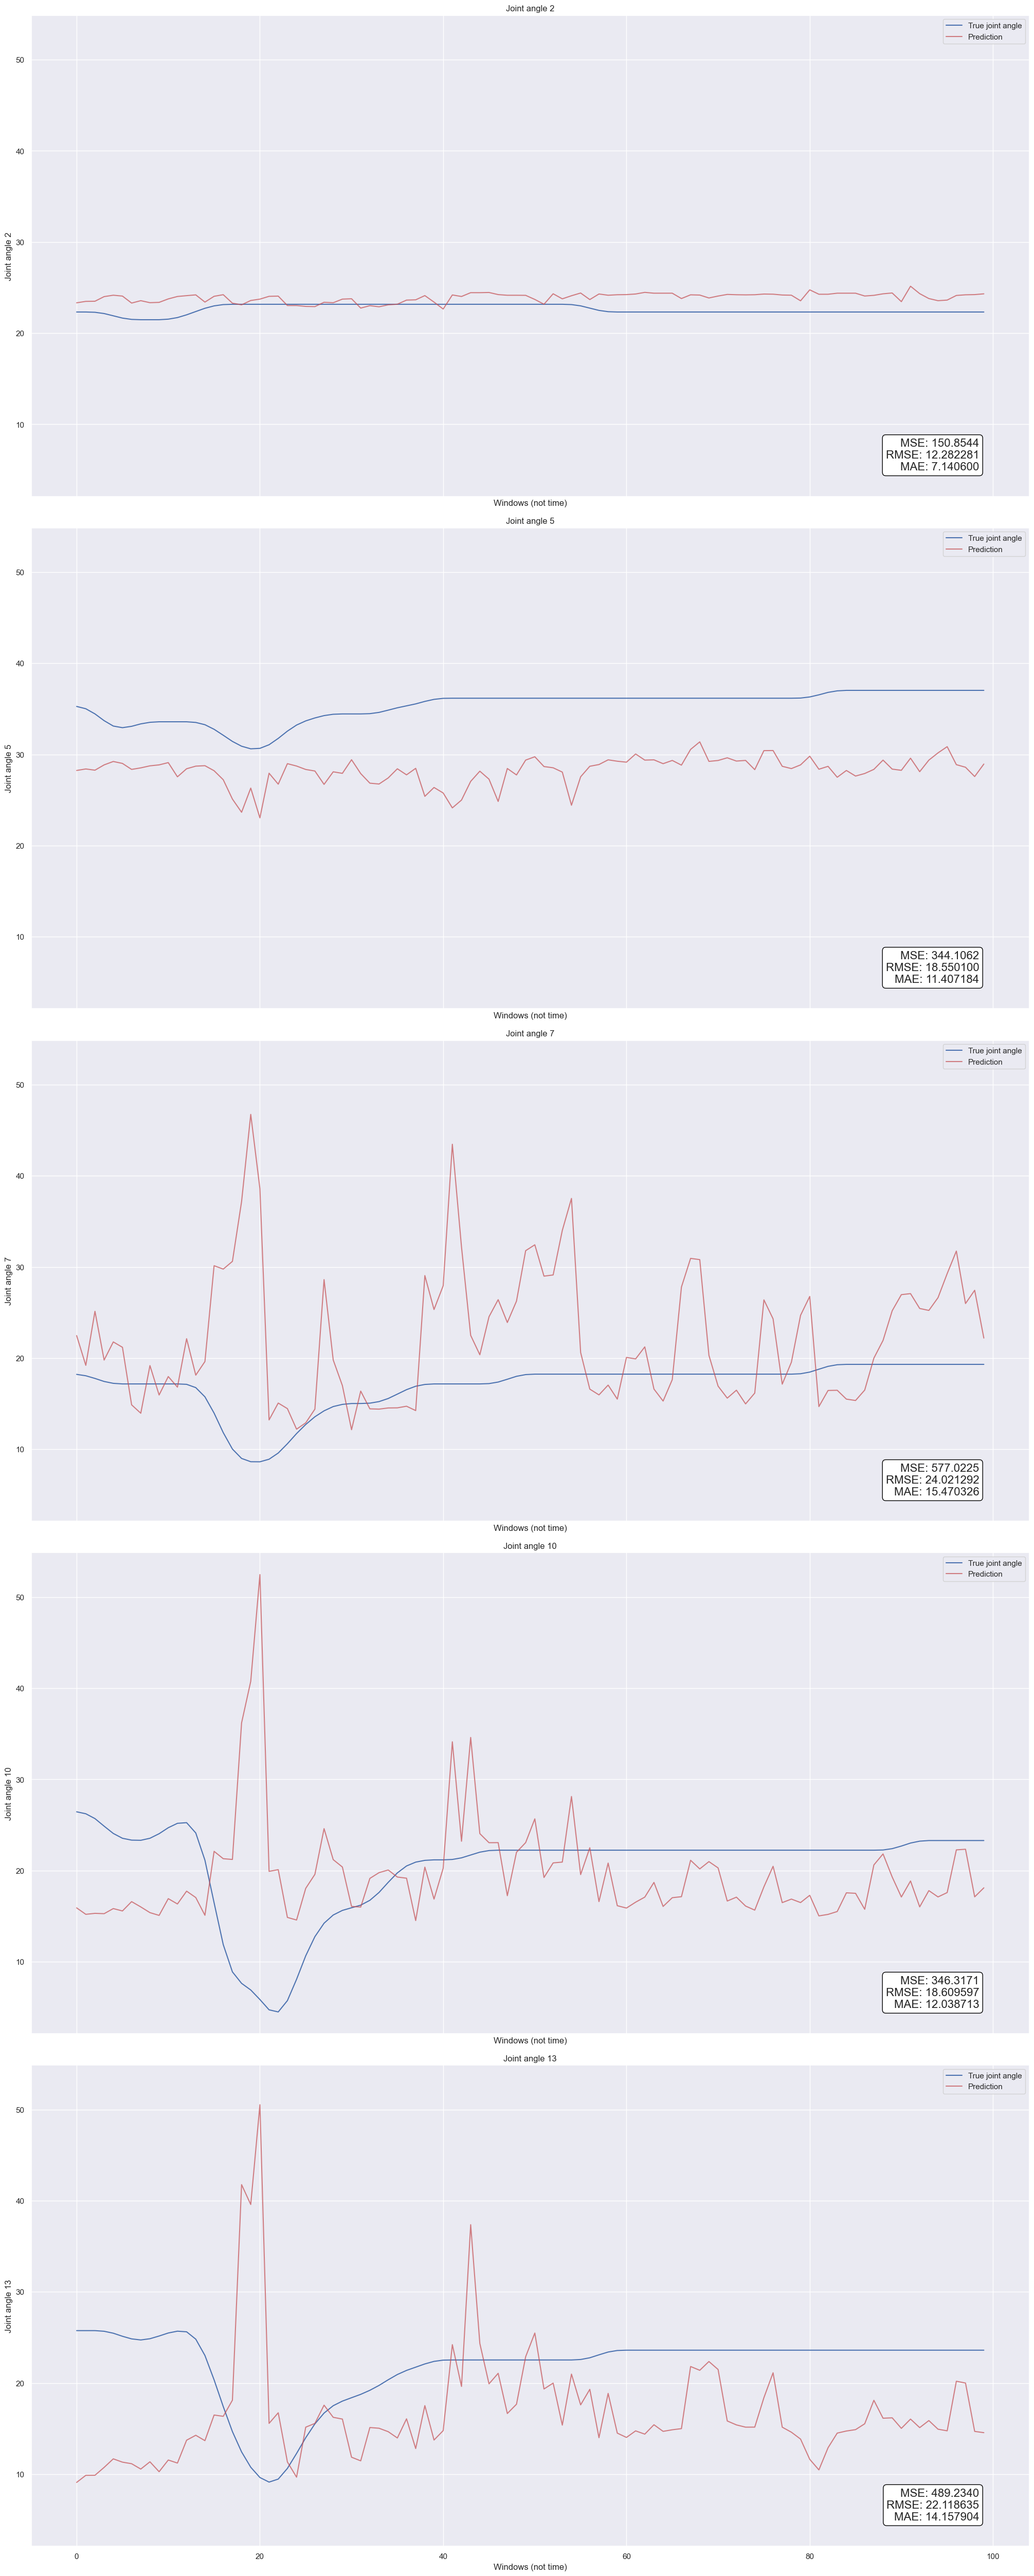

Done


In [64]:
#Useful to answer to the question: Is there a joint angle for which the predictions are less good than usual? 
nb_windows_t_print = 100
save_figures_path = "Figures_Part3/"

fig, ax = plt.subplots(n_joints, 1, constrained_layout=True, figsize=(20, 50), sharex=True, sharey=True)
for i in range(n_joints):
    x = np.arange(nb_windows_t_print)
    ax[i].plot(x, Y_test[:nb_windows_t_print, i], color='b', label='True joint angle')
    ax[i].plot(x, Y_pred[:nb_windows_t_print, i], color='r', alpha=0.7, label='Prediction')
    ax[i].set_xlabel("Windows (not time)")
    ax[i].set_ylabel(f"Joint angle {joints_of_interest[i]+1}")
    ax[i].set_title(f"Joint angle {joints_of_interest[i]+1}")

    ax[i].text(
        0.95, 0.05, f'MSE: {mse[i]:.4f}\nRMSE: {rmse[i]:4f}\nMAE: {mae[i]:4f}',
        transform=ax[i].transAxes,
        fontsize=16,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax[i].legend()

plt.savefig(save_figures_path + "correlation_matrix_means.png", dpi=300, bbox_inches="tight")
plt.show()
print("Done")

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
   'estimator__n_estimators': [100, 200, 300],
   'estimator__learning_rate': [0.01, 0.1],
   'estimator__max_depth': [3, 5, 7],
   'estimator__min_samples_split': [2, 5],
   'estimator__subsample': [0.8, 1.0]
}


# Define the base model
base_model = GradientBoostingRegressor(random_state=42)

# Wrap the model in MultiOutputRegressor
multi_model = MultiOutputRegressor(base_model)

grid_search = GridSearchCV(
   estimator=multi_model,
   param_grid=param_grid,
   cv=5,
   n_jobs=-1,
   verbose=2,
   scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, Y_train)

#Print the outcomes of the grid search:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

final_model = grid_search.best_estimator_

Y_pred = final_model.predict(X_test)


print("Done")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=37.5min
[CV] END estimator__learning_rate=0.01, estimator__max_depth=7, estimator__min_samples_split=2, estimator__n_estimators=200, estimator__subsample=0.8; total time=84.9min
[CV] END estimator__learning_rate=0.1, estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=200, estimator__subsample=1.0; total time=79.0min
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=0.8; total time=18.7min
[CV] END estimator__learning_rate=0.01, estimator__max_depth=5, estimator__min_samples_split=5, estimator__n_estimators=100, estimator__subsample=1.0; total time=38.4min
[CV] END estimator__learning_rate=0.01, estimator__max_depth=7, estimator__min_samples_sp

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the base model
base_model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, random_state=42)


Y_train.shape


# Wrap the model in MultiOutputRegressor
multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, Y_train)
Y_pred = multi_model.predict(X_test)

print("Done")
#Compute the errors. Each column is the error for a target

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')

print(mse.shape)